<a href="https://colab.research.google.com/github/mzffreyvazov/ai-experiments/blob/main/dtsu/air_quality_analysis_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# init environment
from io import BytesIO
from zipfile import ZipFile
from urllib.request import urlopen

import numpy as np
import pandas as pd
import scipy.stats as st
import math
import matplotlib.text as plttxt

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
plt.style.use('bmh')

from dateutil import parser

from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.svm import SVR

from sklearn.linear_model import BayesianRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score

from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import r2_score

from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import RepeatedKFold, cross_validate
from sklearn.compose import TransformedTargetRegressor, make_column_transformer
from sklearn.metrics import PredictionErrorDisplay, median_absolute_error, mean_absolute_error
import scipy as sp
from sklearn.linear_model import RidgeCV, LassoCV


# from regressors.stats import coef_pval
%matplotlib inline

## Reading and Formatting data

In [ ]:
file_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00360/AirQualityUCI.zip'
resp = urlopen(file_url)
zipfile = ZipFile(BytesIO(resp.read()))
data = zipfile.open('AirQualityUCI.csv')
df = pd.read_csv(data, sep=';')

In [ ]:
df.head(5)

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,Unnamed: 15,Unnamed: 16
0,10/03/2004,18.00.00,"2,6",1360.0,150.0,"11,9",1046.0,166.0,1056.0,113.0,1692.0,1268.0,"13,6","48,9","0,7578",NaN,NaN
1,10/03/2004,19.00.00,2,1292.0,112.0,"9,4",955.0,103.0,1174.0,92.0,1559.0,972.0,"13,3","47,7","0,7255",NaN,NaN
2,10/03/2004,20.00.00,"2,2",1402.0,88.0,"9,0",939.0,131.0,1140.0,114.0,1555.0,1074.0,"11,9","54,0","0,7502",NaN,NaN
3,10/03/2004,21.00.00,"2,2",1376.0,80.0,"9,2",948.0,172.0,1092.0,122.0,1584.0,1203.0,"11,0","60,0","0,7867",NaN,NaN
4,10/03/2004,22.00.00,"1,6",1272.0,51.0,"6,5",836.0,131.0,1205.0,116.0,1490.0,1110.0,"11,2","59,6","0,7888",NaN,NaN


In [ ]:
df.shape

(9471, 17)

In [ ]:
# cleaning the empty rows
# checking only for date is enough, as the other columns mean nothing without date
print(df[df['Date'].isnull()].head(30))
print(df[df['Date'].isnull()].shape)

     Date Time CO(GT)  PT08.S1(CO)  NMHC(GT) C6H6(GT)  PT08.S2(NMHC)  NOx(GT)  \
9357  NaN  NaN    NaN          NaN       NaN      NaN            NaN      NaN   
9358  NaN  NaN    NaN          NaN       NaN      NaN            NaN      NaN   
9359  NaN  NaN    NaN          NaN       NaN      NaN            NaN      NaN   
9360  NaN  NaN    NaN          NaN       NaN      NaN            NaN      NaN   
9361  NaN  NaN    NaN          NaN       NaN      NaN            NaN      NaN   
9362  NaN  NaN    NaN          NaN       NaN      NaN            NaN      NaN   
9363  NaN  NaN    NaN          NaN       NaN      NaN            NaN      NaN   
9364  NaN  NaN    NaN          NaN       NaN      NaN            NaN      NaN   
9365  NaN  NaN    NaN          NaN       NaN      NaN            NaN      NaN   
9366  NaN  NaN    NaN          NaN       NaN      NaN            NaN      NaN   
9367  NaN  NaN    NaN          NaN       NaN      NaN            NaN      NaN   
9368  NaN  NaN    NaN       

In [ ]:
# drop the rows where only all the columns are empty
df.dropna(how='all', inplace=True)
df.shape # must return: 9471-114 = 9357

(9357, 17)

In [ ]:
# last two columns are empty, so drop them
[df['Unnamed: 16'].unique(),  df['Unnamed: 16'].unique()]
df.drop(columns=['Unnamed: 15', 'Unnamed: 16'], inplace=True)

In [ ]:
df.shape # must return: 17-2 = 15

(9357, 15)

#### lets start formatting the data

In [ ]:
df.dtypes

Date              object
Time              object
CO(GT)            object
PT08.S1(CO)      float64
NMHC(GT)         float64
C6H6(GT)          object
PT08.S2(NMHC)    float64
NOx(GT)          float64
PT08.S3(NOx)     float64
NO2(GT)          float64
PT08.S4(NO2)     float64
PT08.S5(O3)      float64
T                 object
RH                object
AH                object
dtype: object

In [ ]:
df['Date'].head(5)

0    10/03/2004
1    10/03/2004
2    10/03/2004
3    10/03/2004
4    10/03/2004
Name: Date, dtype: object

In [ ]:
df['Time'].head(5)

0    18.00.00
1    19.00.00
2    20.00.00
3    21.00.00
4    22.00.00
Name: Time, dtype: object

In [ ]:
# let's convert the date and time columns to datetime
# we firs combine it into DateTime, then feature engineer from it
datetime_str = df['Date'] + ' ' + df['Time']
df['DateTime'] = pd.to_datetime(datetime_str, format='%d/%m/%Y %H.%M.%S')

In [ ]:
df.shape

(9357, 16)

In [ ]:
df["Year"] = df["DateTime"].dt.year
df["Month"] = df["DateTime"].dt.month
df["Day"] = df["DateTime"].dt.day
df["Hour"] = df["DateTime"].dt.hour
df["DayOfWeek"] = df["DateTime"].dt.dayofweek

In [ ]:
df['DayOfYear'] = df['DateTime'].dt.dayofyear

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9357 entries, 0 to 9356
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Date           9357 non-null   object        
 1   Time           9357 non-null   object        
 2   CO(GT)         9357 non-null   object        
 3   PT08.S1(CO)    9357 non-null   float64       
 4   NMHC(GT)       9357 non-null   float64       
 5   C6H6(GT)       9357 non-null   object        
 6   PT08.S2(NMHC)  9357 non-null   float64       
 7   NOx(GT)        9357 non-null   float64       
 8   PT08.S3(NOx)   9357 non-null   float64       
 9   NO2(GT)        9357 non-null   float64       
 10  PT08.S4(NO2)   9357 non-null   float64       
 11  PT08.S5(O3)    9357 non-null   float64       
 12  T              9357 non-null   object        
 13  RH             9357 non-null   object        
 14  AH             9357 non-null   object        
 15  DateTime       9357 non-nu

In [ ]:
# cyclic encoding for time features
df['Hour_sin'] = np.sin(2 * np.pi * df['Hour'] / 24.0)
df['Hour_cos'] = np.cos(2 * np.pi * df['Hour'] / 24.0)

df['Month_sin'] = np.sin(2 * np.pi * df['Month'] / 12.0)
df['Month_cos'] = np.cos(2 * np.pi * df['Month'] / 12.0)

df['DayOfWeek_sin'] = np.sin(2 * np.pi * df['DayOfWeek'] / 7.0)
df['DayOfWeek_cos'] = np.cos(2 * np.pi * df['DayOfWeek'] / 7.0)

In [ ]:
df.shape

(9357, 28)

In [ ]:
df.columns

Index(['Date', 'Time', 'CO(GT)', 'PT08.S1(CO)', 'NMHC(GT)', 'C6H6(GT)',
       'PT08.S2(NMHC)', 'NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)',
       'PT08.S5(O3)', 'T', 'RH', 'AH', 'DateTime', 'Year', 'Month', 'Day',
       'Hour', 'DayOfWeek', 'DayOfYear', 'Hour_sin', 'Hour_cos', 'Month_sin',
       'Month_cos', 'DayOfWeek_sin', 'DayOfWeek_cos'],
      dtype='object')

In [ ]:
df = df.drop(columns=['Date', 'Time'])

In [ ]:
# lets encode the other categorical columns
df['T'] = df['T'].map(lambda x: float(x.replace(',','.')))
df['RH'] = df['RH'].map(lambda x: float(x.replace(',','.')))
df['AH'] = df['AH'].map(lambda x: float(x.replace(',','.')))

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9357 entries, 0 to 9356
Data columns (total 26 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   CO(GT)         9357 non-null   object        
 1   PT08.S1(CO)    9357 non-null   float64       
 2   NMHC(GT)       9357 non-null   float64       
 3   C6H6(GT)       9357 non-null   object        
 4   PT08.S2(NMHC)  9357 non-null   float64       
 5   NOx(GT)        9357 non-null   float64       
 6   PT08.S3(NOx)   9357 non-null   float64       
 7   NO2(GT)        9357 non-null   float64       
 8   PT08.S4(NO2)   9357 non-null   float64       
 9   PT08.S5(O3)    9357 non-null   float64       
 10  T              9357 non-null   float64       
 11  RH             9357 non-null   float64       
 12  AH             9357 non-null   float64       
 13  DateTime       9357 non-null   datetime64[ns]
 14  Year           9357 non-null   int32         
 15  Month          9357 non-nu

In [ ]:
# lets now encode C6H6(GT) and CO(GT) columns (the last ones)
# first check
print(df['C6H6(GT)'].head())
print(df['CO(GT)'].head())

0    11,9
1     9,4
2     9,0
3     9,2
4     6,5
Name: C6H6(GT), dtype: object
0    2,6
1      2
2    2,2
3    2,2
4    1,6
Name: CO(GT), dtype: object


In [ ]:
df['C6H6(GT)'] = df['C6H6(GT)'].map(lambda x: float(x.replace(',','.')) if isinstance(x, str) else x)
df['CO(GT)'] = df['CO(GT)'].map(lambda x: float(x.replace(',','.')) if isinstance(x, str) else x)

In [ ]:
print(df['C6H6(GT)'].head(5))
print(df['CO(GT)'].head(5))
print(df[['C6H6(GT)', 'CO(GT)']].dtypes)

0    11.9
1     9.4
2     9.0
3     9.2
4     6.5
Name: C6H6(GT), dtype: float64
0    2.6
1    2.0
2    2.2
3    2.2
4    1.6
Name: CO(GT), dtype: float64
C6H6(GT)    float64
CO(GT)      float64
dtype: object


In [ ]:
# lets now verify the whole dataset (every column is numeric)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9357 entries, 0 to 9356
Data columns (total 26 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   CO(GT)         9357 non-null   float64       
 1   PT08.S1(CO)    9357 non-null   float64       
 2   NMHC(GT)       9357 non-null   float64       
 3   C6H6(GT)       9357 non-null   float64       
 4   PT08.S2(NMHC)  9357 non-null   float64       
 5   NOx(GT)        9357 non-null   float64       
 6   PT08.S3(NOx)   9357 non-null   float64       
 7   NO2(GT)        9357 non-null   float64       
 8   PT08.S4(NO2)   9357 non-null   float64       
 9   PT08.S5(O3)    9357 non-null   float64       
 10  T              9357 non-null   float64       
 11  RH             9357 non-null   float64       
 12  AH             9357 non-null   float64       
 13  DateTime       9357 non-null   datetime64[ns]
 14  Year           9357 non-null   int32         
 15  Month          9357 non-nu

#### now lets deal with the missin/nan/incorrect values

In [ ]:
print(df.isna().sum())

CO(GT)           0
PT08.S1(CO)      0
NMHC(GT)         0
C6H6(GT)         0
PT08.S2(NMHC)    0
NOx(GT)          0
PT08.S3(NOx)     0
NO2(GT)          0
PT08.S4(NO2)     0
PT08.S5(O3)      0
T                0
RH               0
AH               0
DateTime         0
Year             0
Month            0
Day              0
Hour             0
DayOfWeek        0
DayOfYear        0
Hour_sin         0
Hour_cos         0
Month_sin        0
Month_cos        0
DayOfWeek_sin    0
DayOfWeek_cos    0
dtype: int64


In [ ]:
df = df.replace(-200, np.nan)

In [ ]:
print(df.isna().sum())

CO(GT)           1683
PT08.S1(CO)       366
NMHC(GT)         8443
C6H6(GT)          366
PT08.S2(NMHC)     366
NOx(GT)          1639
PT08.S3(NOx)      366
NO2(GT)          1642
PT08.S4(NO2)      366
PT08.S5(O3)       366
T                 366
RH                366
AH                366
DateTime            0
Year                0
Month               0
Day                 0
Hour                0
DayOfWeek           0
DayOfYear           0
Hour_sin            0
Hour_cos            0
Month_sin           0
Month_cos           0
DayOfWeek_sin       0
DayOfWeek_cos       0
dtype: int64


In [ ]:
# lets analyze the missing values to decide on the imputation strategy
df.describe()

,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),...,Day,Hour,DayOfWeek,DayOfYear,Hour_sin,Hour_cos,Month_sin,Month_cos,DayOfWeek_sin,DayOfWeek_cos
count,7674.000000,8991.000000,914.000000,8991.000000,8991.000000,7718.000000,8991.000000,7715.000000,8991.000000,8991.000000,...,9357.000000,9357.000000,9357.000000,9357.000000,9.357000e+03,9.357000e+03,9.357000e+03,9.357000e+03,9357.000000,9357.000000
mean,2.152750,1099.833166,218.811816,10.083105,939.153376,246.896735,835.493605,113.091251,1456.264598,1022.906128,...,15.876884,11.498557,3.009939,177.295928,2.713539e-04,1.566662e-04,5.751905e-02,-6.870216e-03,-0.003881,-0.002133
min,0.100000,647.000000,7.000000,0.100000,383.000000,2.000000,322.000000,2.000000,551.000000,221.000000,...,1.000000,0.000000,0.000000,1.000000,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-0.974928,-0.900969
25%,1.100000,937.000000,67.000000,4.400000,734.500000,98.000000,658.000000,78.000000,1227.000000,731.500000,...,8.000000,5.000000,1.000000,84.000000,-7.071068e-01,-7.071068e-01,-5.000000e-01,-5.000000e-01,-0.781831,-0.900969
50%,1.800000,1063.000000,150.000000,8.200000,909.000000,180.000000,806.000000,109.000000,1463.000000,963.000000,...,16.000000,11.000000,3.000000,172.000000,1.224647e-16,6.123234e-17,1.224647e-16,6.123234e-17,0.000000,-0.222521
75%,2.900000,1231.000000,297.000000,14.000000,1116.000000,326.000000,969.500000,142.000000,1674.000000,1273.500000,...,23.000000,18.000000,5.000000,269.000000,7.071068e-01,7.071068e-01,8.660254e-01,5.000000e-01,0.781831,0.623490
max,11.900000,2040.000000,1189.000000,63.700000,2214.000000,1479.000000,2683.000000,340.000000,2775.000000,2523.000000,...,31.000000,23.000000,6.000000,366.000000,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.974928,1.000000
std,1.453252,217.080037,204.459921,7.449820,266.831429,212.979168,256.817320,48.370108,346.206794,398.484288,...,8.808653,6.923182,2.000323,105.230605,7.070929e-01,7.071962e-01,7.241552e-01,6.872774e-01,0.706659,0.707616


In [ ]:
# from df.isna().sum(), we can see that the total missing value for NMHC(GT) is 8443
# we can drop this column, since it is too much and have no value
df.drop(columns=['NMHC(GT)'], inplace=True)

In [ ]:
# dealing with the missing values in all other columns
print(df[['CO(GT)', 'NOx(GT)', 'NO2(GT)']].describe())


            CO(GT)      NOx(GT)      NO2(GT)
count  7674.000000  7718.000000  7715.000000
mean      2.152750   246.896735   113.091251
std       1.453252   212.979168    48.370108
min       0.100000     2.000000     2.000000
25%       1.100000    98.000000    78.000000
50%       1.800000   180.000000   109.000000
75%       2.900000   326.000000   142.000000
max      11.900000  1479.000000   340.000000


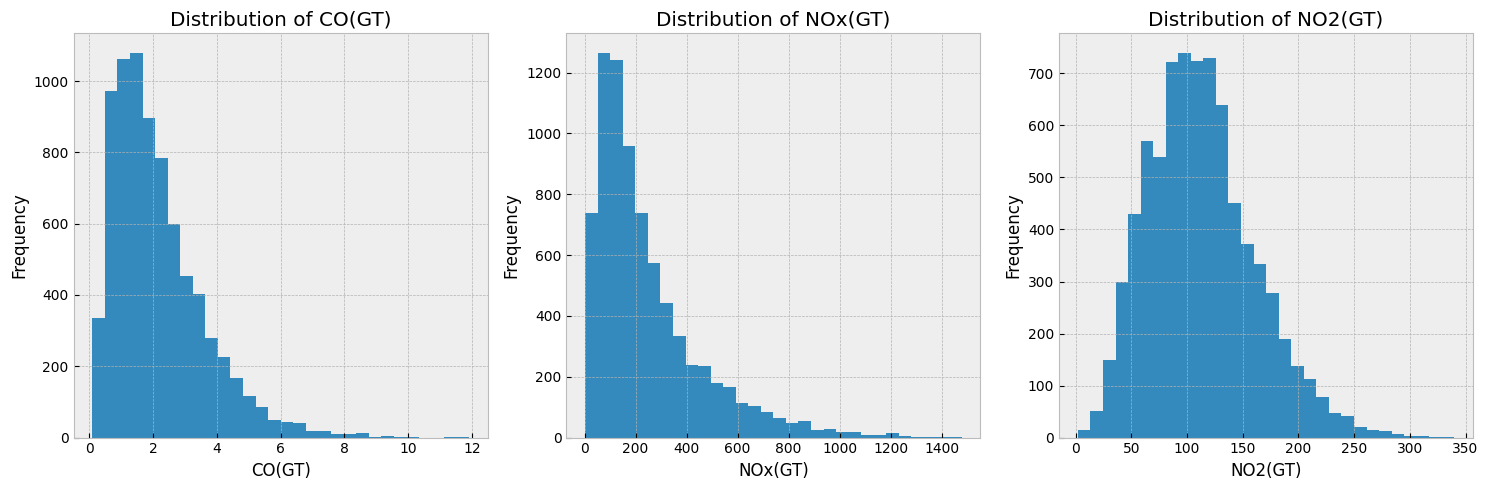

In [ ]:
plt.figure(figsize=(15, 5))
for i, col in enumerate(['CO(GT)', 'NOx(GT)', 'NO2(GT)']):
    plt.subplot(1, 3, i+1)
    df[col].hist(bins=30)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

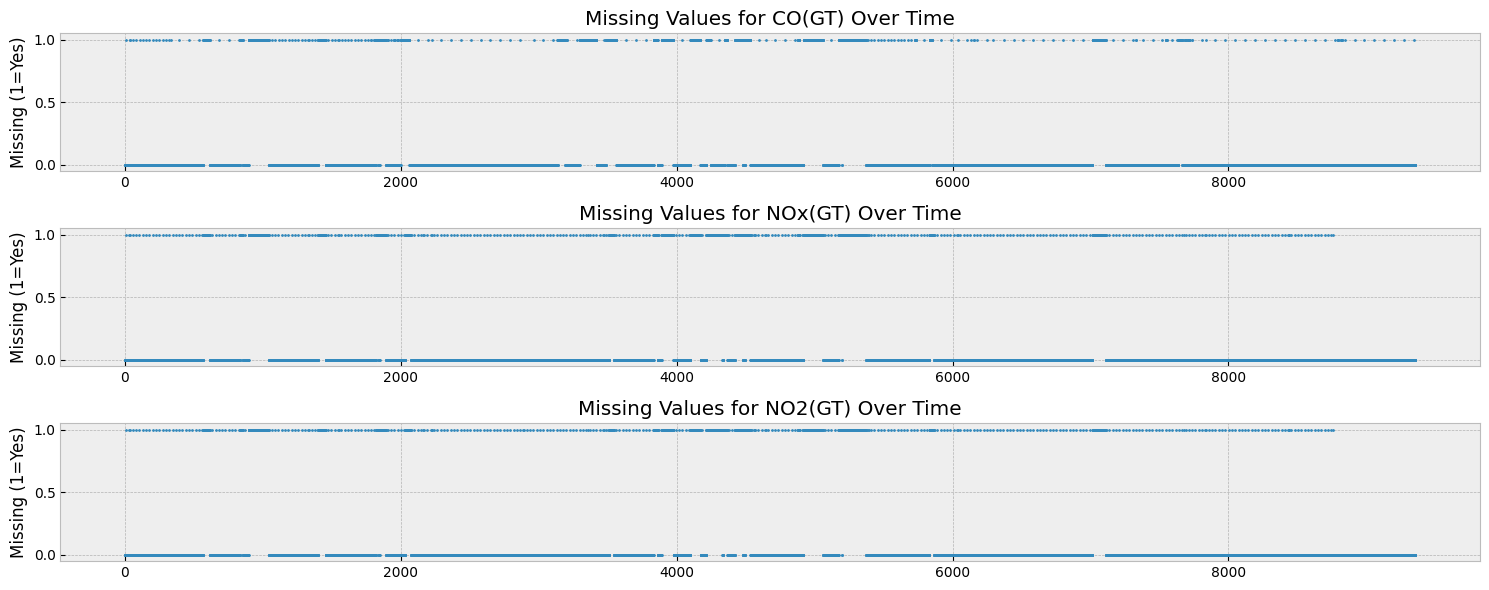

Correlation of missing values:
           CO(GT)   NOx(GT)   NO2(GT)
CO(GT)   1.000000  0.681687  0.680802
NOx(GT)  0.681687  1.000000  0.998892
NO2(GT)  0.680802  0.998892  1.000000


In [ ]:
# Check if missing values occur in specific time periods
plt.figure(figsize=(15, 6))
for i, col in enumerate(['CO(GT)', 'NOx(GT)', 'NO2(GT)']):
    plt.subplot(3, 1, i+1)
    plt.plot(df.index, df[col].isna().astype(int), '.', markersize=2)
    plt.title(f'Missing Values for {col} Over Time')
    plt.ylabel('Missing (1=Yes)')
plt.tight_layout()
plt.show()

# Check if missing values occur together
missing_correlation = df[['CO(GT)', 'NOx(GT)', 'NO2(GT)']].isna().corr()
print("Correlation of missing values:")
print(missing_correlation)

Correlation between gas measurements and sensors:
                CO(GT)  PT08.S1(CO)   NOx(GT)  PT08.S3(NOx)   NO2(GT)  \
CO(GT)        1.000000     0.879288  0.795028     -0.703446  0.683343   
PT08.S1(CO)   0.879288     1.000000  0.713654     -0.771938  0.641529   
NOx(GT)       0.795028     0.713654  1.000000     -0.655707  0.763111   
PT08.S3(NOx) -0.703446    -0.771938 -0.655707      1.000000 -0.652083   
NO2(GT)       0.683343     0.641529  0.763111     -0.652083  1.000000   
PT08.S4(NO2)  0.630703     0.682881  0.233731     -0.538468  0.157360   

              PT08.S4(NO2)  
CO(GT)            0.630703  
PT08.S1(CO)       0.682881  
NOx(GT)           0.233731  
PT08.S3(NOx)     -0.538468  
NO2(GT)           0.157360  
PT08.S4(NO2)      1.000000  


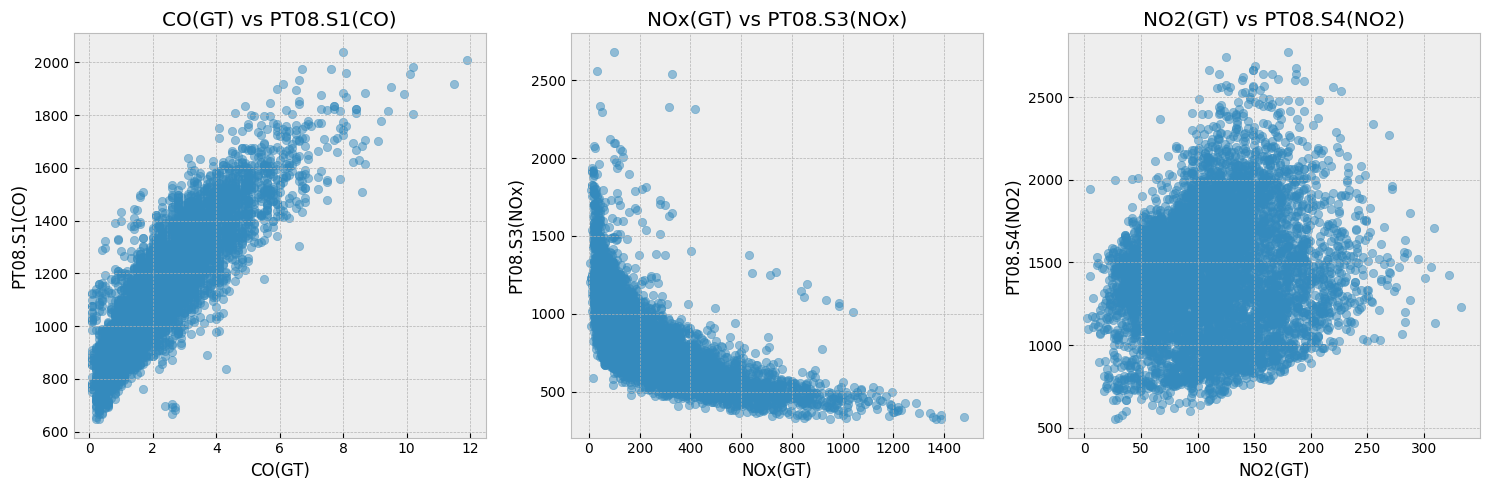

In [ ]:
# Create correlation matrix with sensor measurements
corr_cols = ['CO(GT)', 'PT08.S1(CO)', 'NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)']
corr_matrix = df[corr_cols].corr()
print("Correlation between gas measurements and sensors:")
print(corr_matrix)

# Visualize relationships between original measurements and sensor readings
plt.figure(figsize=(15, 5))
for i, (gas, sensor) in enumerate([('CO(GT)', 'PT08.S1(CO)'),
                                  ('NOx(GT)', 'PT08.S3(NOx)'),
                                  ('NO2(GT)', 'PT08.S4(NO2)')]):
    plt.subplot(1, 3, i+1)
    plt.scatter(df[gas], df[sensor], alpha=0.5)
    plt.title(f'{gas} vs {sensor}')
    plt.xlabel(gas)
    plt.ylabel(sensor)
plt.tight_layout()
plt.show()

In [ ]:
df.columns

Index(['CO(GT)', 'PT08.S1(CO)', 'C6H6(GT)', 'PT08.S2(NMHC)', 'NOx(GT)',
       'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)', 'PT08.S5(O3)', 'T', 'RH',
       'AH', 'DateTime', 'Year', 'Month', 'Day', 'Hour', 'DayOfWeek',
       'DayOfYear', 'Hour_sin', 'Hour_cos', 'Month_sin', 'Month_cos',
       'DayOfWeek_sin', 'DayOfWeek_cos'],
      dtype='object')

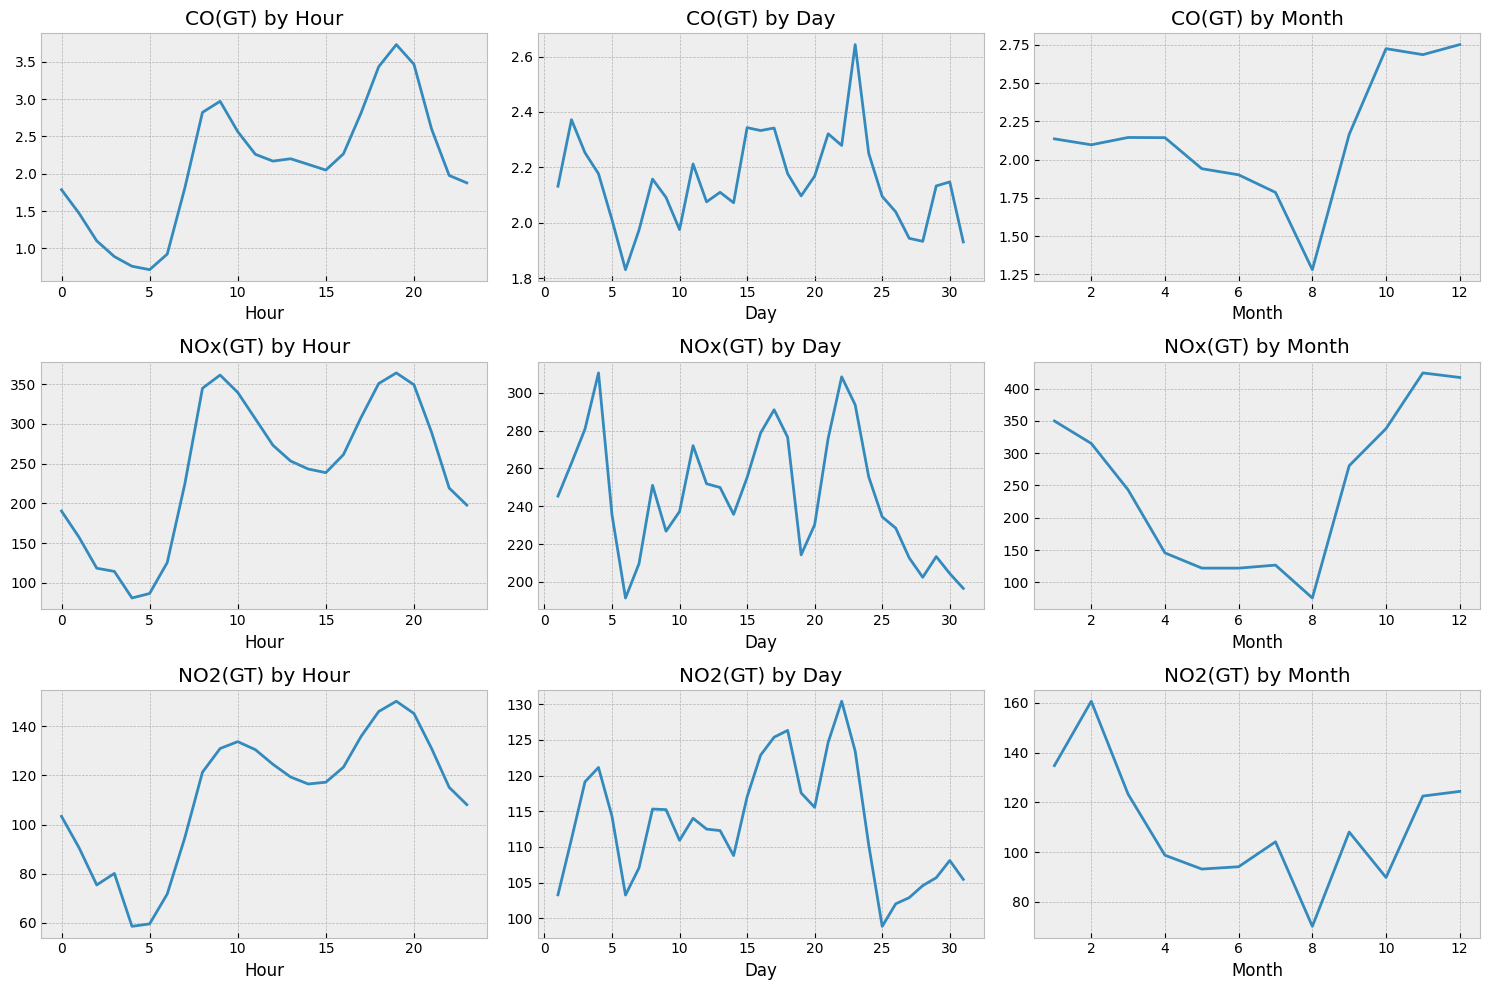

In [ ]:
plt.figure(figsize=(15, 10))
for i, col in enumerate(['CO(GT)', 'NOx(GT)', 'NO2(GT)']):
    # Hourly pattern
    plt.subplot(3, 3, i*3+1)
    df.groupby('Hour')[col].mean().plot()
    plt.title(f'{col} by Hour')

    # Daily pattern
    plt.subplot(3, 3, i*3+2)
    df.groupby('Day')[col].mean().plot()
    plt.title(f'{col} by Day')

    # Monthly pattern
    plt.subplot(3, 3, i*3+3)
    df.groupby('Month')[col].mean().plot()
    plt.title(f'{col} by Month')
plt.tight_layout()
plt.show()

In [ ]:
print(df.isna().sum())

CO(GT)           1683
PT08.S1(CO)       366
C6H6(GT)          366
PT08.S2(NMHC)     366
NOx(GT)          1639
PT08.S3(NOx)      366
NO2(GT)          1642
PT08.S4(NO2)      366
PT08.S5(O3)       366
T                 366
RH                366
AH                366
DateTime            0
Year                0
Month               0
Day                 0
Hour                0
DayOfWeek           0
DayOfYear           0
Hour_sin            0
Hour_cos            0
Month_sin           0
Month_cos           0
DayOfWeek_sin       0
DayOfWeek_cos       0
dtype: int64


In [ ]:
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler

print("Original DataFrame Info:")
df.info()
print("\nOriginal missing values count:")
print(df.isnull().sum())


Original DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
Index: 9357 entries, 0 to 9356
Data columns (total 25 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   CO(GT)         7674 non-null   float64       
 1   PT08.S1(CO)    8991 non-null   float64       
 2   C6H6(GT)       8991 non-null   float64       
 3   PT08.S2(NMHC)  8991 non-null   float64       
 4   NOx(GT)        7718 non-null   float64       
 5   PT08.S3(NOx)   8991 non-null   float64       
 6   NO2(GT)        7715 non-null   float64       
 7   PT08.S4(NO2)   8991 non-null   float64       
 8   PT08.S5(O3)    8991 non-null   float64       
 9   T              8991 non-null   float64       
 10  RH             8991 non-null   float64       
 11  AH             8991 non-null   float64       
 12  DateTime       9357 non-null   datetime64[ns]
 13  Year           9357 non-null   int32         
 14  Month          9357 non-null   int32         
 15  D

In [ ]:
# --- 2. Identify Columns for Imputation ---
cols_to_impute_and_predict = [
    'CO(GT)', 'PT08.S1(CO)', 'C6H6(GT)', 'PT08.S2(NMHC)', 'NOx(GT)',
    'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)', 'PT08.S5(O3)',
    'T', 'RH', 'AH'
]
cols_to_impute_and_predict = [col for col in cols_to_impute_and_predict if col in df.columns]


# List columns that are known to be COMPLETE and useful as predictors
complete_predictor_cols = [
    'Hour_sin', 'Hour_cos', 'Month_sin', 'Month_cos',
    'DayOfWeek_sin', 'DayOfWeek_cos'
]
complete_predictor_cols = [col for col in complete_predictor_cols if col in df.columns]

all_cols_for_imputer = complete_predictor_cols + cols_to_impute_and_predict

missing_in_df = [col for col in all_cols_for_imputer if col not in df.columns]
if missing_in_df:
    print(f"\n--- WARNING ---")
    print(f"The following specified columns are NOT in the DataFrame: {missing_in_df}")
    print(f"Please check the column names in the lists above.")
    print(f"Proceeding with columns found: {[col for col in all_cols_for_imputer if col in df.columns]}")
    all_cols_for_imputer = [col for col in all_cols_for_imputer if col in df.columns] # Adjust list
else:
    print(f"\nColumns selected for imputation process: {all_cols_for_imputer}")

df_for_imputation = df[all_cols_for_imputer]

# --- 3. Scaling (Recommended for KNNImputer) ---
print("\nScaling data for KNNImputer...")
scaler = MinMaxScaler() # Or StandardScaler()

scaler.fit(df_for_imputation)

df_scaled_array = scaler.transform(df_for_imputation)

# Convert scaled array back to DataFrame temporarily (keeps column names and index)
df_scaled = pd.DataFrame(df_scaled_array, columns=all_cols_for_imputer, index=df_for_imputation.index)
print("Scaling complete.")

# --- 4. Perform Imputation ---

# Using KNNImputer
print("\nStarting KNN Imputation...")
imputer = KNNImputer(n_neighbors=5)

# Fit the imputer and transform the scaled data
imputed_scaled_array = imputer.fit_transform(df_scaled)
print("KNN Imputation finished.")


# --- 5. Inverse Scaling ---
print("\nInverse scaling imputed data...")
# Transform the imputed data back to the original scale using the fitted scaler
imputed_array = scaler.inverse_transform(imputed_scaled_array)
print("Inverse scaling complete.")

# --- 6. Update Original DataFrame ---
df_imputed_final = pd.DataFrame(imputed_array, columns=all_cols_for_imputer, index=df_for_imputation.index)

print("\nUpdating original DataFrame with imputed values...")
cols_actually_imputed = [col for col in cols_to_impute_and_predict if col in df.columns] # Re-check existence
for col in cols_actually_imputed:
    df[col] = df_imputed_final[col]
print("DataFrame update complete.")

# --- 7. Verification ---

print("\nMissing values count AFTER imputation:")
print(df[cols_actually_imputed].isnull().sum())

print("\nTotal missing values remaining in DataFrame:", df.isnull().sum().sum())

print("\nDataFrame Info after imputation:")
df.info()
print("\nDataFrame head after imputation:")
print(df.head())

print("\n--- Important Reminder ---")
print("For final model training/evaluation to predict 'RH',")
print("it's generally recommended to remove rows where 'RH'")
print("was *originally* missing (before imputation), even though it's now filled.")
print("You might need to create a boolean mask *before* running this imputation")
print("script to track those original missing locations if you haven't already.")


Columns selected for imputation process: ['Hour_sin', 'Hour_cos', 'Month_sin', 'Month_cos', 'DayOfWeek_sin', 'DayOfWeek_cos', 'CO(GT)', 'PT08.S1(CO)', 'C6H6(GT)', 'PT08.S2(NMHC)', 'NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)', 'PT08.S5(O3)', 'T', 'RH', 'AH']

Scaling data for KNNImputer...
Scaling complete.

Starting KNN Imputation...
KNN Imputation finished.

Inverse scaling imputed data...
Inverse scaling complete.

Updating original DataFrame with imputed values...
DataFrame update complete.

Missing values count AFTER imputation:
CO(GT)           0
PT08.S1(CO)      0
C6H6(GT)         0
PT08.S2(NMHC)    0
NOx(GT)          0
PT08.S3(NOx)     0
NO2(GT)          0
PT08.S4(NO2)     0
PT08.S5(O3)      0
T                0
RH               0
AH               0
dtype: int64

Total missing values remaining in DataFrame: 0

DataFrame Info after imputation:
<class 'pandas.core.frame.DataFrame'>
Index: 9357 entries, 0 to 9356
Data columns (total 25 columns):
 #   Column         Non-Nul

## Building the model

In [ ]:
df_modeling = df.copy()


#### selecting features and targets

In [ ]:
target_col = 'RH'

feature_cols = [
    'CO(GT)', 'PT08.S1(CO)', 'C6H6(GT)', 'PT08.S2(NMHC)', 'NOx(GT)',
    'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)', 'PT08.S5(O3)',
    'T', 'AH',
    'Hour_sin', 'Hour_cos', 'Month_sin', 'Month_cos',
    'DayOfWeek_sin', 'DayOfWeek_cos'
]

feature_cols = [col for col in feature_cols if col in df_modeling.columns]
print(f"\nFeatures being used: {feature_cols}")

# Separate features (X) and target (y)
X = df_modeling[feature_cols]
y = df_modeling[target_col]

print(f"\nShape of features (X): {X.shape}")
print(f"Shape of target (y): {y.shape}")


Features being used: ['CO(GT)', 'PT08.S1(CO)', 'C6H6(GT)', 'PT08.S2(NMHC)', 'NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)', 'PT08.S5(O3)', 'T', 'AH', 'Hour_sin', 'Hour_cos', 'Month_sin', 'Month_cos', 'DayOfWeek_sin', 'DayOfWeek_cos']

Shape of features (X): (9357, 17)
Shape of target (y): (9357,)


#### splitting the data into training and test

In [ ]:
from sklearn.model_selection import train_test_split

# Option 1: Chronological Split (for Time Series)
test_size_percentage = 0.2
split_index = int(len(X) * (1 - test_size_percentage))

X_train = X[:split_index]
X_test = X[split_index:]
y_train = y[:split_index]
y_test = y[split_index:]

print("\nUsing chronological split:")
print(f"Training set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")


Using chronological split:
Training set size: 7485
Test set size: 1872


#### feature scaling

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=feature_cols, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=feature_cols, index=X_test.index)

print("\nFeatures scaled using StandardScaler (fitted on training data).")
print("Scaled training data head:\n", X_train_scaled.head())


Features scaled using StandardScaler (fitted on training data).
Scaled training data head:
      CO(GT)  PT08.S1(CO)  C6H6(GT)  PT08.S2(NMHC)   NOx(GT)  PT08.S3(NOx)  \
0  0.314966     1.191504  0.175040       0.328246 -0.274350      0.805406   
1 -0.103611     0.879219 -0.158430      -0.017321 -0.584402      1.263990   
2  0.035915     1.384386 -0.211785      -0.078080 -0.446601      1.131856   
3  0.035915     1.264983 -0.185108      -0.043903 -0.244821      0.945313   
4 -0.382662     0.787371 -0.545255      -0.469216 -0.446601      1.384465   

    NO2(GT)  PT08.S4(NO2)  PT08.S5(O3)         T        AH  Hour_sin  \
0  0.309427      0.501803     0.641321 -0.814320 -0.977682 -1.414823   
1 -0.196355      0.072826    -0.133127 -0.850858 -1.064143 -1.366630   
2  0.333512      0.059924     0.133744 -1.021365 -0.998026 -1.225337   
3  0.526191      0.153461     0.471256 -1.130977 -0.900321 -1.000571   
4  0.381682     -0.149726     0.227933 -1.106619 -0.894700 -0.707651   

   Hour_cos

#### choose and train model

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# --- Model 1: Linear Regression (Baseline) ---
print("\n--- Training Linear Regression ---")
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)

# --- Model 2: Random Forest Regressor ---
print("\n--- Training Random Forest Regressor ---")
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1, max_depth=15, min_samples_split=5) # Start with default or slightly tuned parameters
rf_model.fit(X_train_scaled, y_train)

print("\nModels trained successfully.")


--- Training Linear Regression ---

--- Training Random Forest Regressor ---

Models trained successfully.


#### make predictions and evaluate

In [ ]:
# --- Evaluate Linear Regression ---
print("\n--- Evaluating Linear Regression ---")
y_pred_lr = lr_model.predict(X_test_scaled)

mae_lr = mean_absolute_error(y_test, y_pred_lr)
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))
r2_lr = r2_score(y_test, y_pred_lr)

print(f"Mean Absolute Error (MAE): {mae_lr:.3f}")
print(f"Root Mean Squared Error (RMSE): {rmse_lr:.3f}")
print(f"R-squared (R²): {r2_lr:.3f}")

# --- Evaluate Random Forest ---
print("\n--- Evaluating Random Forest Regressor ---")
y_pred_rf = rf_model.predict(X_test_scaled)

mae_rf = mean_absolute_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)

print(f"Mean Absolute Error (MAE): {mae_rf:.3f}")
print(f"Root Mean Squared Error (RMSE): {rmse_rf:.3f}")
print(f"R-squared (R²): {r2_rf:.3f}")


--- Evaluating Linear Regression ---
Mean Absolute Error (MAE): 6.923
Root Mean Squared Error (RMSE): 8.483
R-squared (R²): 0.732

--- Evaluating Random Forest Regressor ---
Mean Absolute Error (MAE): 1.473
Root Mean Squared Error (RMSE): 2.667
R-squared (R²): 0.973


#### feature importance


--- Random Forest Feature Importances ---
          Feature  Importance
9               T    0.628945
10             AH    0.321057
14      Month_cos    0.046459
12       Hour_cos    0.000655
11       Hour_sin    0.000595
4         NOx(GT)    0.000259
13      Month_sin    0.000248
7    PT08.S4(NO2)    0.000247
15  DayOfWeek_sin    0.000246
6         NO2(GT)    0.000226
8     PT08.S5(O3)    0.000209
5    PT08.S3(NOx)    0.000209
1     PT08.S1(CO)    0.000209
16  DayOfWeek_cos    0.000148
0          CO(GT)    0.000120
2        C6H6(GT)    0.000085
3   PT08.S2(NMHC)    0.000084


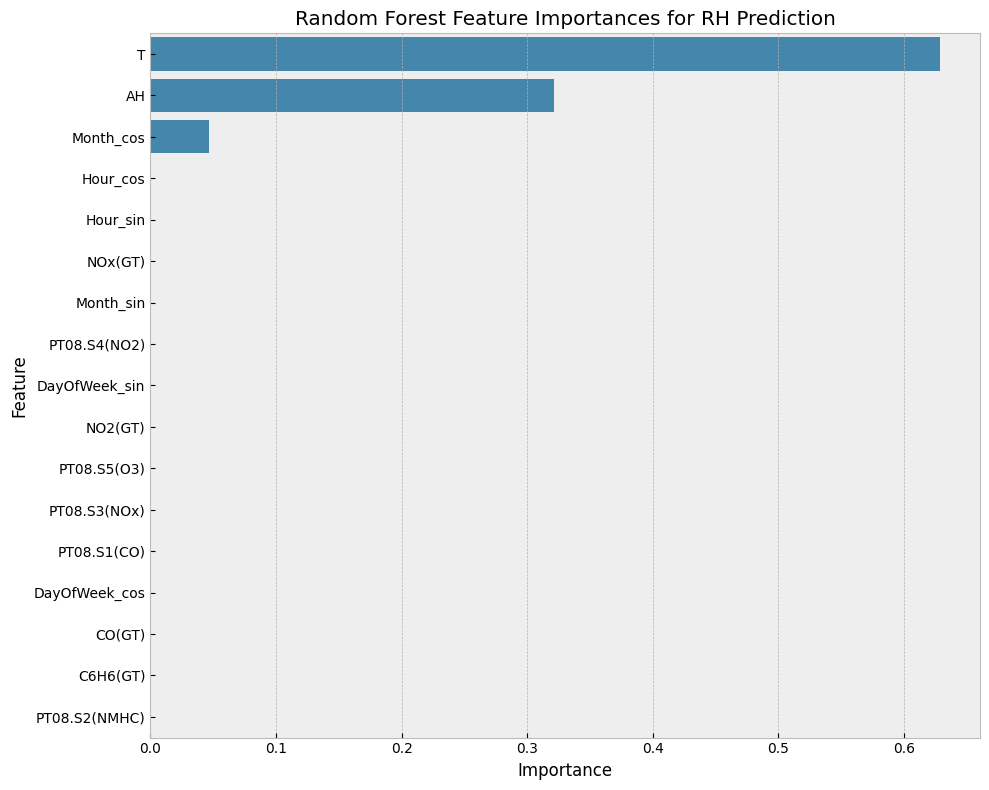

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

print("\n--- Random Forest Feature Importances ---")

importances = rf_model.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print(feature_importance_df)

# Plot feature importances
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Random Forest Feature Importances for RH Prediction')
plt.tight_layout()
plt.show()

#### linear regression models (improvements)

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, SGDRegressor, RidgeCV, LassoCV, ElasticNetCV
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


print("--- Data Preparation ---")
target_col = 'RH'

X = df_modeling[feature_cols]
y = df_modeling[target_col]

# --- Chronological Split ---
test_size_percentage = 0.2
split_index = int(len(X) * (1 - test_size_percentage))
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]
print(f"Using chronological split: Train={len(X_train)}, Test={len(X_test)}")

# --- Model Definitions ---
poly_degree = 2

# Define models to try
models = {
    "Linear Regression": LinearRegression(),
    "Ridge (alpha=1.0)": Ridge(alpha=1.0, random_state=42), # Basic Ridge
    "Lasso (alpha=0.1)": Lasso(alpha=0.1, random_state=42, max_iter=5000), # Basic Lasso, might need higher alpha/max_iter
    "ElasticNet (alpha=0.1)": ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=42, max_iter=5000), # Basic ElasticNet
    "SGDRegressor (L2)": SGDRegressor(penalty='l2', random_state=42, max_iter=1000, tol=1e-3), # Like Ridge
    "SGDRegressor (L1)": SGDRegressor(penalty='l1', random_state=42, max_iter=1000, tol=1e-3), # Like Lasso
    "SGDRegressor (ElasticNet)": SGDRegressor(penalty='elasticnet', random_state=42, max_iter=1000, tol=1e-3) # Like ElasticNet
}

results = {}

# --- Training and Evaluation Loop ---

print(f"\n--- Training Models with PolynomialFeatures(degree={poly_degree}) & StandardScaler ---")

for name, model in models.items():
    print(f"Training {name}...")

    # Create the pipeline
    pipeline = Pipeline([
        ('poly', PolynomialFeatures(degree=poly_degree, include_bias=False)), # Create interactions/powers
        ('scaler', StandardScaler()), # Scale features
        ('regressor', model) # Apply the regression model
    ])

    # Train the pipeline
    pipeline.fit(X_train, y_train)

    # Predict on test data
    y_pred = pipeline.predict(X_test)

    # Evaluate
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    results[name] = {'MAE': mae, 'RMSE': rmse, 'R2': r2}

    print(f"  MAE: {mae:.3f}, RMSE: {rmse:.3f}, R²: {r2:.3f}")

print("\n--- Comparison of Linear Models (with Polynomial Features) ---")
results_df = pd.DataFrame(results).T.sort_values(by='R2', ascending=False)
print(results_df)

if "Lasso (alpha=0.1)" in models:
    print("\n--- Lasso Coefficients Analysis ---")
    pipeline_lasso = Pipeline([
        ('poly', PolynomialFeatures(degree=poly_degree, include_bias=False)),
        ('scaler', StandardScaler()),
        ('regressor', models["Lasso (alpha=0.1)"])
    ])
    pipeline_lasso.fit(X_train, y_train)

    poly_feature_names = pipeline_lasso.named_steps['poly'].get_feature_names_out(X_train.columns)
    lasso_coefs = pipeline_lasso.named_steps['regressor'].coef_

    coef_df = pd.DataFrame({'Feature': poly_feature_names, 'Coefficient': lasso_coefs})
    print("Features selected by Lasso (non-zero coefficients):")
    print(coef_df[coef_df['Coefficient'] != 0].sort_values(by='Coefficient', key=abs, ascending=False))

--- Data Preparation ---
Using chronological split: Train=7485, Test=1872

--- Training Models with PolynomialFeatures(degree=2) & StandardScaler ---
Training Linear Regression...
  MAE: 2.819, RMSE: 3.602, R²: 0.952
Training Ridge (alpha=1.0)...
  MAE: 2.371, RMSE: 3.214, R²: 0.961
Training Lasso (alpha=0.1)...
  MAE: 4.200, RMSE: 5.154, R²: 0.901
Training ElasticNet (alpha=0.1)...
  MAE: 4.973, RMSE: 6.180, R²: 0.857
Training SGDRegressor (L2)...
  MAE: 2.402, RMSE: 3.396, R²: 0.957
Training SGDRegressor (L1)...
  MAE: 2.360, RMSE: 3.323, R²: 0.959
Training SGDRegressor (ElasticNet)...
  MAE: 2.483, RMSE: 3.490, R²: 0.955

--- Comparison of Linear Models (with Polynomial Features) ---
                                MAE      RMSE        R2
Ridge (alpha=1.0)          2.371118  3.213881  0.961461
SGDRegressor (L1)          2.360067  3.322895  0.958802
SGDRegressor (L2)          2.401607  3.396246  0.956963
SGDRegressor (ElasticNet)  2.482628  3.489749  0.954561
Linear Regression       